In [2]:
import torch
import torchvision
from pathlib import Path

/home/yuvrajsingh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchinfo
from torch import nn
from torchvision import transforms

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
     

'cuda'

In [5]:
data_path = Path("data2/")

In [6]:
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
#Transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(test_dir, transform=data_transform, target_transform=None)


In [14]:
from torch.utils.data import DataLoader
import os

In [15]:
train_dataloader = DataLoader(dataset=train_data, num_workers=os.cpu_count(), batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, num_workers=os.cpu_count(), batch_size=32, shuffle=True)

In [16]:
class_names = train_data.class_to_idx

In [17]:
class_names = class_names.keys()


In [18]:
class_names = list(class_names)
class_names

['pizza', 'steak', 'sushi']

In [26]:

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 


pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)


for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit.heads = nn.Sequential(
    nn.Dropout(p=0.1),
    nn.Linear(in_features=768, out_features=len(class_names)).to(device)
)


In [35]:
class_names

['pizza', 'steak', 'sushi']

In [58]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, number_of_patches, embedding_d\imension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [36]:
from going_modular.going_modular import data_setup

In [28]:
#Get the required transformation for a particular model--> here vit base 16
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [38]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [39]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=2,
                                      device=device)

 10%|█         | 1/10 [00:05<00:48,  5.42s/it]

Epoch: 1 | train_loss: 0.7853 | train_acc: 0.7031 | test_loss: 0.5748 | test_acc: 0.7860


 20%|██        | 2/10 [00:09<00:36,  4.59s/it]

Epoch: 2 | train_loss: 0.4218 | train_acc: 0.9336 | test_loss: 0.3986 | test_acc: 0.8371


 30%|███       | 3/10 [00:13<00:30,  4.34s/it]

Epoch: 3 | train_loss: 0.2302 | train_acc: 0.9531 | test_loss: 0.3485 | test_acc: 0.8371


 40%|████      | 4/10 [00:17<00:25,  4.25s/it]

Epoch: 4 | train_loss: 0.1961 | train_acc: 0.9688 | test_loss: 0.2836 | test_acc: 0.8778


 50%|█████     | 5/10 [00:21<00:20,  4.14s/it]

Epoch: 5 | train_loss: 0.1489 | train_acc: 0.9648 | test_loss: 0.2299 | test_acc: 0.8873


 60%|██████    | 6/10 [00:25<00:16,  4.10s/it]

Epoch: 6 | train_loss: 0.1322 | train_acc: 0.9688 | test_loss: 0.2220 | test_acc: 0.8873


 70%|███████   | 7/10 [00:29<00:12,  4.06s/it]

Epoch: 7 | train_loss: 0.1230 | train_acc: 0.9727 | test_loss: 0.2289 | test_acc: 0.8873


 80%|████████  | 8/10 [00:33<00:08,  4.05s/it]

Epoch: 8 | train_loss: 0.0967 | train_acc: 0.9727 | test_loss: 0.2269 | test_acc: 0.8977


 90%|█████████ | 9/10 [00:37<00:04,  4.03s/it]

Epoch: 9 | train_loss: 0.0871 | train_acc: 0.9805 | test_loss: 0.2371 | test_acc: 0.8977


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]

Epoch: 10 | train_loss: 0.0844 | train_acc: 0.9844 | test_loss: 0.2325 | test_acc: 0.8977


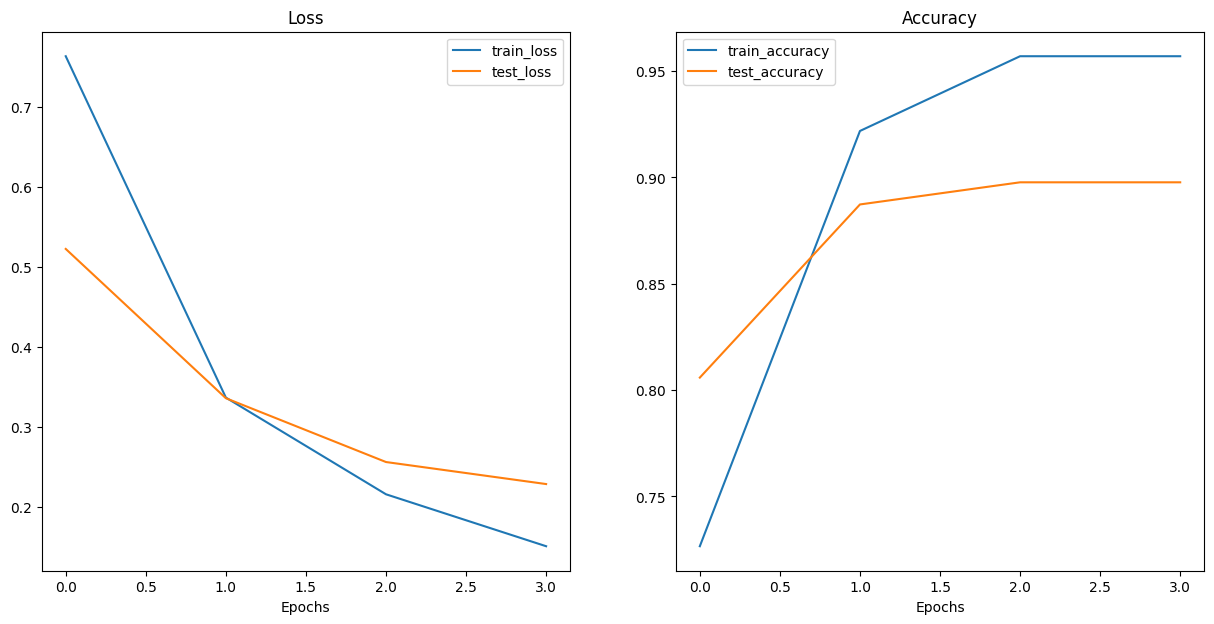

In [36]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [34]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="vit_feature_pretrained_b_16_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/vit_feature_pretrained_b_16_extractor_pizza_steak_sushi.pth


In [63]:
#Saving best model
from going_modular.going_modular import utils
utils.save_model(pretrained_vit, target_dir="best_model", model_name="pretrained_vit_b_16_pizza_sushi_steak_20_percent.pth")

[INFO] Saving model to: best_model/pretrained_vit_b_16_pizza_sushi_steak_20_percent.pth


In [44]:
#Gradio Overview

In [10]:
!pip install gradio

In [11]:
import gradio as gr
import PIL

In [19]:
class_names

['pizza', 'steak', 'sushi']

In [38]:
def predict(image, model):
    img = pretrained_vit_transforms(image).unsqueeze(0)
    
    pretrained_vit.eval()
    with torch.inference_mode():
        preds  = torch.softmax(model(img), dim=1)
        prediction_labels = class_names[torch.argmax(preds).item()]
        return preds, prediction_labels

In [30]:

best_model_path = Path('best_model/pretrained_vit_b_16_pizza_sushi_steak_20_percent.pth')
loaded_pretrained_vit_weights = torch.load(best_model_path)

loaded_pretrained_vit = torchvision.models.vit_b_16(weights=loaded_pretrained_vit_weights).to('cpu')
# loaded_pretrained_vit_weights = torch.load(best_model_path)


loaded_pretrained_vit.heads = nn.Sequential(
    nn.Dropout(p=0.1),
    nn.Linear(in_features=768, out_features=len(class_names)).to('cpu')
)




/home/yuvrajsingh/anaconda3/envs/py311/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
predict(PIL.Image.open("data2/pizza_steak_sushi/test/steak/354513.jpg"), loaded_pretrained_vit)

(tensor([[0.1864, 0.3562, 0.4575]]), 'sushi')